*Python Machine Learning 3rd Edition* by [Sebastian Raschka](https://sebastianraschka.com), Packt Publishing Ltd. 2019

Code Repository: https://github.com/rasbt/python-machine-learning-book-3rd-edition

Code License: [MIT License](https://github.com/rasbt/python-machine-learning-book-2nd-edition/blob/master/LICENSE.txt)

# Python Machine Learning - Code Examples

# Chapter 9 - Embedding a Machine Learning Model into a Web Application

Note that the optional watermark extension is a small IPython notebook plugin that I developed to make the code reproducible. You can just skip the following line(s).

In [2]:
%load_ext watermark
%watermark -a "Sebastian Raschka" -u -d -v -p numpy,pandas,pyprind,matplotlib,nltk,sklearn,flask

Author: Sebastian Raschka

Last updated: 2022-08-06

Python implementation: CPython
Python version       : 3.9.5
IPython version      : 7.30.1

numpy     : 1.20.3
pandas    : 1.3.0
pyprind   : 2.11.2
matplotlib: 3.3.4
nltk      : 3.6.7
sklearn   : 1.1.1
flask     : not installed



*The use of `watermark` is optional. You can install this Jupyter extension via*  

    conda install watermark -c conda-forge  

or  

    pip install watermark   

*For more information, please see: https://github.com/rasbt/watermark.*

In [3]:
from IPython.display import Image

<br>
<br>

### Overview

- [Chapter 8 recap - Training a model for movie review classification](#Chapter-6-recap---Training-a-model-for-movie-review-classification)

- [Serializing fitted scikit-learn estimators](#Serializing-fitted-scikit-learn-estimators)
- [Setting up a SQLite database for data storage Developing a web application with Flask](#Setting-up-a-SQLite-database-for-data-storage-Developing-a-web-application-with-Flask)
- [Our first Flask web application](#Our-first-Flask-web-application)
  - [Form validation and rendering](#Form-validation-and-rendering)
  - [Turning the movie classifier into a web application](#Turning-the-movie-classifier-into-a-web-application)
- [Deploying the web application to a public server](#Deploying-the-web-application-to-a-public-server)
  - [Updating the movie review classifier](#Updating-the-movie-review-classifier)
- [Summary](#Summary)

The code for the Flask web applications can be found in the following directories:
    
- `1st_flask_app_1/`: A simple Flask web app
- `1st_flask_app_2/`: `1st_flask_app_1` extended with flexible form validation and rendering
- `movieclassifier/`: The movie classifier embedded in a web application
- `movieclassifier_with_update/`: same as `movieclassifier` but with update from sqlite database upon start

To run the web applications locally, `cd` into the respective directory (as listed above) and execute the main-application script, for example,

    cd ./1st_flask_app_1
    python3 app.py
    
Now, you should see something like
    
     * Running on http://127.0.0.1:5000/
     * Restarting with reloader
     
in your terminal.
Next, open a web browsert and enter the address displayed in your terminal (typically http://127.0.0.1:5000/) to view the web application.

**Link to a live example application built with this tutorial: http://raschkas.pythonanywhere.com/**.

<br>
<br>

# Chapter 8 recap - Training a model for movie review classification

This section is a recap of the logistic regression model that was trained in the last section of Chapter 6. Execute the following code blocks to train a model that we will serialize in the next section.

**Note**

The code below is based on the `movie_data.csv` dataset that was created in Chapter 8

In [4]:
import gzip

with gzip.open('movie_data.csv.gz') as f_in, open('movie_data.csv', 'wb') as f_out:
    f_out.writelines(f_in)

In [5]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dunca\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

stop = stopwords.words('english')
porter = PorterStemmer()

def tokenizer(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text.lower())
    text = re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', '')
    tokenized = [w for w in text.split() if w not in stop]
    return tokenized

def stream_docs(path):
    with open(path, 'r', encoding='utf-8') as csv:
        next(csv) # skip header
        for line in csv:
            text, label = line[:-3], int(line[-2])
            yield text, label

In [7]:
next(stream_docs(path='movie_data.csv'))

('"In 1974, the teenager Martha Moxley (Maggie Grace) moves to the high-class area of Belle Haven, Greenwich, Connecticut. On the Mischief Night, eve of Halloween, she was murdered in the backyard of her house and her murder remained unsolved. Twenty-two years later, the writer Mark Fuhrman (Christopher Meloni), who is a former LA detective that has fallen in disgrace for perjury in O.J. Simpson trial and moved to Idaho, decides to investigate the case with his partner Stephen Weeks (Andrew Mitchell) with the purpose of writing a book. The locals squirm and do not welcome them, but with the support of the retired detective Steve Carroll (Robert Forster) that was in charge of the investigation in the 70\'s, they discover the criminal and a net of power and money to cover the murder.<br /><br />""Murder in Greenwich"" is a good TV movie, with the true story of a murder of a fifteen years old girl that was committed by a wealthy teenager whose mother was a Kennedy. The powerful and rich f

In [8]:
def get_minibatch(doc_stream, size):
    docs, y = [], []
    try:
        for _ in range(size):
            text, label = next(doc_stream)
            docs.append(text)
            y.append(label)
    except StopIteration:
        return None, None
    return docs, y

In [9]:
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier

vect = HashingVectorizer(decode_error='ignore', 
                         n_features=2**21,
                         preprocessor=None, 
                         tokenizer=tokenizer)

clf = SGDClassifier(loss='log', random_state=1, max_iter=1)
doc_stream = stream_docs(path='movie_data.csv')

In [10]:
import pyprind
pbar = pyprind.ProgBar(45)

classes = np.array([0, 1])
for _ in range(45):
    X_train, y_train = get_minibatch(doc_stream, size=1000)
    if not X_train:
        break
    X_train = vect.transform(X_train)
    clf.partial_fit(X_train, y_train, classes=classes)
    pbar.update()

C:\Users\dunca\anaconda3\envs\GIS\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
C:\Users\dunca\anaconda3\envs\GIS\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
0% [#                             ] 100% | ETA: 00:01:15C:\Users\dunca\anaconda3\envs\GIS\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
0% [##                            ] 100% | ETA: 00:01:05C:\Users\dunca\anaconda3\envs\GIS\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was

In [11]:
X_test, y_test = get_minibatch(doc_stream, size=5000)
X_test = vect.transform(X_test)
print('Accuracy: %.3f' % clf.score(X_test, y_test))

Accuracy: 0.868


In [12]:
clf = clf.partial_fit(X_test, y_test)

C:\Users\dunca\anaconda3\envs\GIS\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


### Note

The pickling-section may be a bit tricky so that I included simpler test scripts in this directory (`pickle-test-scripts/`) to check if your environment is set up correctly. Basically, it is just a trimmed-down version of the relevant sections from `Ch08`, including a very small `movie_data` subset.

Executing

    python pickle-dump-test.py

will train a small classification model from the `movie_data_small.csv` and create the 2 pickle files 

    stopwords.pkl
    classifier.pkl

Next, if you execute

    python pickle-load-test.py

You should see the following 2 lines as output:

    Prediction: positive
    Probability: 85.71%

In [13]:
def get_minibatch(doc_stream, size):
    docs, y = [], []
    try:
        for _ in range(size):
            text, label = next(doc_stream)
            docs.append(text)
            y.append(label)
    except StopIteration:
        return None, None
    return docs, y

In [14]:
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier

vect = HashingVectorizer(decode_error='ignore', 
                         n_features=2**21,
                         preprocessor=None, 
                         tokenizer=tokenizer)

clf = SGDClassifier(loss='log', random_state=1, max_iter=1)
doc_stream = stream_docs(path='movie_data.csv')

In [15]:
import pyprind
pbar = pyprind.ProgBar(45)


classes = np.array([0, 1])
for _ in range(45):
    X_train, y_train = get_minibatch(doc_stream, size=1000)
    if not X_train:
        break
    X_train = vect.transform(X_train)
    clf.partial_fit(X_train, y_train, classes=classes)
    pbar.update()

C:\Users\dunca\anaconda3\envs\GIS\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
0% [#                             ] 100% | ETA: 00:00:26C:\Users\dunca\anaconda3\envs\GIS\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
0% [##                            ] 100% | ETA: 00:00:26C:\Users\dunca\anaconda3\envs\GIS\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
C:\Users\dunca\anaconda3\envs\GIS\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was

In [16]:
X_test, y_test = get_minibatch(doc_stream, size=5000)
X_test = vect.transform(X_test)
print('Accuracy: %.3f' % clf.score(X_test, y_test))

Accuracy: 0.868


In [17]:
clf = clf.partial_fit(X_test, y_test)

C:\Users\dunca\anaconda3\envs\GIS\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


<br>
<br>

# Serializing fitted scikit-learn estimators

After we trained the logistic regression model as shown above, we now save the classifier along woth the stop words, Porter Stemmer, and `HashingVectorizer` as serialized objects to our local disk so that we can use the fitted classifier in our web application later.

In [18]:
import pickle
import os

dest = os.path.join('movieclassifier', 'pkl_objects')
if not os.path.exists(dest):
    os.makedirs(dest)

pickle.dump(stop, open(os.path.join(dest, 'stopwords.pkl'), 'wb'), protocol=4)   
pickle.dump(clf, open(os.path.join(dest, 'classifier.pkl'), 'wb'), protocol=4)

Next, we save the `HashingVectorizer` as in a separate file so that we can import it later.

In [19]:
%%writefile movieclassifier/vectorizer.py
from sklearn.feature_extraction.text import HashingVectorizer
import re
import os
import pickle

cur_dir = os.path.dirname(__file__)
stop = pickle.load(open(
                os.path.join(cur_dir, 
                'pkl_objects', 
                'stopwords.pkl'), 'rb'))

def tokenizer(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text.lower())
    text = re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', '')
    tokenized = [w for w in text.split() if w not in stop]
    return tokenized

vect = HashingVectorizer(decode_error='ignore',
                         n_features=2**21,
                         preprocessor=None,
                         tokenizer=tokenizer)

Overwriting movieclassifier/vectorizer.py


After executing the preceeding code cells, we can now restart the IPython notebook kernel to check if the objects were serialized correctly.

First, change the current Python directory to `movieclassifer`:

In [20]:
import os
os.chdir('movieclassifier')

In [21]:
import pickle
import re
import os
from vectorizer import vect

clf = pickle.load(open(os.path.join('pkl_objects', 'classifier.pkl'), 'rb'))

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\dunca\\Dropbox (Personal)\\Duncan\\GITHUB_REPOSITORY\\DU_MSDS\\Machine_Learning\\python-machine-learning-book-3rd-edition-master\\python-machine-learning-book-3rd-edition-master\\ch09\\pkl_objects\\stopwords.pkl'

In [22]:
import numpy as np
label = {0:'negative', 1:'positive'}

example = ["I love this movie. It's amazing."]
X = vect.transform(example)
print('Prediction: %s\nProbability: %.2f%%' %\
      (label[clf.predict(X)[0]], 
       np.max(clf.predict_proba(X))*100))

Prediction: positive
Probability: 95.55%


<br>
<br>

# Setting up a SQLite database for data storage 

Before you execute this code, please make sure that you are currently in the `movieclassifier` directory.

Note that we are still on the "movieclassifier" subdirectory:

In [23]:
os.getcwd()

'C:\\Users\\dunca\\Dropbox (Personal)\\Duncan\\GITHUB_REPOSITORY\\DU_MSDS\\Machine_Learning\\python-machine-learning-book-3rd-edition-master\\python-machine-learning-book-3rd-edition-master\\ch09\\movieclassifier'

In [28]:
import sqlite3
import os

conn = sqlite3.connect('reviews.sqlite')
c = conn.cursor()

c.execute('DROP TABLE IF EXISTS review_db')
c.execute('CREATE TABLE review_db (review TEXT, sentiment INTEGER, date TEXT)')

example1 = 'I love this movie'
c.execute("INSERT INTO review_db (review, sentiment, date) VALUES (?, ?, DATETIME('now'))", (example1, 1))

example2 = 'I disliked this movie'
c.execute("INSERT INTO review_db (review, sentiment, date) VALUES (?, ?, DATETIME('now'))", (example2, 0))

conn.commit()
conn.close()

In [29]:
conn = sqlite3.connect('reviews.sqlite')
c = conn.cursor()

c.execute("SELECT * FROM review_db WHERE date BETWEEN '2017-01-01 10:10:10' AND DATETIME('now')")
results = c.fetchall()

conn.close()

In [30]:
print(results)

[('I love this movie', 1, '2022-08-06 20:04:50'), ('I disliked this movie', 0, '2022-08-06 20:04:50')]


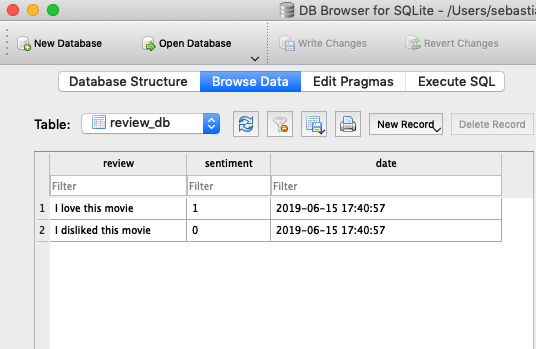

In [31]:
Image(filename='../images/09_01.png', width=700) 

<br>

# Developing a web application with Flask

...

## Our first Flask web application

...

In [ ]:
Image(filename='../images/09_09.png', width=700) 

## Form validation and rendering

In [ ]:
Image(filename='../images/09_02.png', width=400) 

In [ ]:
Image(filename='../images/09_03.png', width=400) 

<br>
<br>

## Summary figures

In [ ]:
Image(filename='./images/09_11.png', width=800) 

In [ ]:
Image(filename='./images/09_12.png', width=800) 

In [ ]:
Image(filename='./images/09_13.png', width=400) 

# Turning the movie classifier into a web application

In [ ]:
Image(filename='../images/09_04.png', width=400) 

In [ ]:
Image(filename='../images/09_05.png', width=400) 

In [ ]:
Image(filename='../images/09_06.png', width=400) 

In [ ]:
Image(filename='../images/09_07.png', width=200) 

In [ ]:
Image(filename='../images/09_10.png', width=400) 

<br>
<br>

# Deploying the web application to a public server

In [ ]:
Image(filename='../images/09_08.png', width=600) 

<br>
<br>

## Updating the movie review classifier

Let us make and operate on a copy of the movieclassifier subdirectory (this should already exist when you downloaded this GitHub repo (otherwise, please duplicate the `movieclassifier` directory).

In [ ]:
import shutil

os.chdir('..')

if not os.path.exists('movieclassifier_with_update'):
    os.mkdir('movieclassifier_with_update')
os.chdir('movieclassifier_with_update')

if not os.path.exists('pkl_objects'):
    os.mkdir('pkl_objects')

shutil.copyfile('../movieclassifier/pkl_objects/classifier.pkl',
                './pkl_objects/classifier.pkl')

shutil.copyfile('../movieclassifier/reviews.sqlite',
                './reviews.sqlite')

Define a function to update the classifier with the data stored in the local SQLite database:

In [ ]:
import pickle
import sqlite3
import numpy as np

# import HashingVectorizer from local dir
from vectorizer import vect

def update_model(db_path, model, batch_size=10000):

    conn = sqlite3.connect(db_path)
    c = conn.cursor()
    c.execute('SELECT * from review_db')
    
    results = c.fetchmany(batch_size)
    while results:
        data = np.array(results)
        X = data[:, 0]
        y = data[:, 1].astype(int)
    
        classes = np.array([0, 1])
        X_train = vect.transform(X)
        clf.partial_fit(X_train, y, classes=classes)
        results = c.fetchmany(batch_size)
    
    conn.close()
    return None

Update the model:

In [ ]:
cur_dir = '.'

# Use the following path instead if you embed this code into
# the app.py file

# import os
# cur_dir = os.path.dirname(__file__)

clf = pickle.load(open(os.path.join(cur_dir,
                 'pkl_objects',
                 'classifier.pkl'), 'rb'))
db = os.path.join(cur_dir, 'reviews.sqlite')

update_model(db_path=db, model=clf, batch_size=10000)

# Uncomment the following lines to update your classifier.pkl file

# pickle.dump(clf, open(os.path.join(cur_dir, 
#             'pkl_objects', 'classifier.pkl'), 'wb')
#             , protocol=4)

<br>
<br>

# Summary

<br>
...
<br>